In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [2]:
# Task 1: Preprocessing

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from catboost import CatBoostClassifier

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

data_path = '/content/amazon_cells_labelled.txt'
data = pd.read_csv(data_path, delimiter='\t', header=None, names=['Review', 'Label'])

print("Original Dataset:")
print(data.head())

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

print("\nApplying Preprocessing...")
data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

print("\nExamples of Preprocessed Data:")
for i in range(3):
    print(f"Original: {data['Review'][i]}\nCleaned: {data['Cleaned_Review'][i]}\n")

output_path = '/content/preprocessed_amazon_reviews.csv'
data.to_csv(output_path, index=False)
print(f"\nPreprocessed data saved to: {output_path}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original Dataset:
                                              Review  Label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1

Applying Preprocessing...

Examples of Preprocessed Data:
Original: So there is no way for me to plug it in here in the US unless I go by a converter.
Cleaned: way plug u unless go converter

Original: Good case, Excellent value.
Cleaned: good case excellent value

Original: Great for the jawbone.
Cleaned: great jawbone


Preprocessed data saved to: /content/preprocessed_amazon_reviews.csv


In [3]:
# Task 2: Classification using Bag-of-Words Representation

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Cleaned_Review'])
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.2f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training Naive Bayes...
Accuracy for Naive Bayes: 0.79
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        93
           1       0.77      0.85      0.81       107

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200


Training Decision Tree...
Accuracy for Decision Tree: 0.76
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75        93
           1       0.79      0.74      0.76       107

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.76       200


Training Random Forest...
Accuracy for Random Forest: 0.79
Classification Report for Random Forest:
              precision    recall  f1-score   sup

In [4]:
# Task 3: Classification using a BERT-based Model

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

label_encoder = LabelEncoder()
data['Encoded_Labels'] = label_encoder.fit_transform(data['Label'])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Encoded_Labels'], test_size=0.2, random_state=42
)

train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_len=128)
test_dataset = TextDataset(test_texts.tolist(), test_labels.tolist(), tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("\nTraining BERT model...")
model.train()

for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

print("\nEvaluating BERT model...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

bert_accuracy = accuracy_score(all_labels, all_preds)
print(f"BERT Model Accuracy: {bert_accuracy:.2f}")
print("Classification Report for BERT:")
print(classification_report(all_labels, all_preds))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training BERT model...
Epoch 1, Loss: 0.4943
Epoch 2, Loss: 0.2842
Epoch 3, Loss: 0.1583

Evaluating BERT model...
BERT Model Accuracy: 0.88
Classification Report for BERT:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        93
           1       0.85      0.94      0.89       107

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



In [5]:
# Task 4: Topic Detection using LDA

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

print("\nLDA Topics:")
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


LDA Topics:
Topic 1: really, look, charger, work, bluetooth, great, good, headset, would, recommend
Topic 2: awesome, color, ive, also, audio, get, good, quality, phone, poor
Topic 3: ear, phone, use, doesnt, good, happy, headset, product, im, work
Topic 4: quality, case, well, fit, price, phone, great, excellent, good, product
Topic 5: buy, use, disappointment, long, bad, one, phone, good, life, battery
Topic 6: battery, bought, device, volume, year, customer, work, phone, service, great
Topic 7: sound, work, month, get, use, worst, item, best, ever, phone
Topic 8: doesnt, case, headset, junk, problem, battery, easy, like, use, phone
Topic 9: purchase, call, quality, better, one, money, sound, waste, phone, dont
Topic 10: first, disappointed, better, new, could, headset, one, thing, love, phone


In [6]:
# CatBoost Classifier

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

catboost_clf = CatBoostClassifier(verbose=0, random_seed=42)
print("\nTraining CatBoost Classifier...")
catboost_clf.fit(X_train_dense, y_train)

y_pred_catboost = catboost_clf.predict(X_test_dense)
catboost_accuracy = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Classifier Accuracy: {catboost_accuracy:.2f}")
print("Classification Report for CatBoost Classifier:")
print(classification_report(y_test, y_pred_catboost))



Training CatBoost Classifier...
CatBoost Classifier Accuracy: 0.75
Classification Report for CatBoost Classifier:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        93
           1       0.84      0.65      0.74       107

    accuracy                           0.75       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.77      0.75      0.75       200



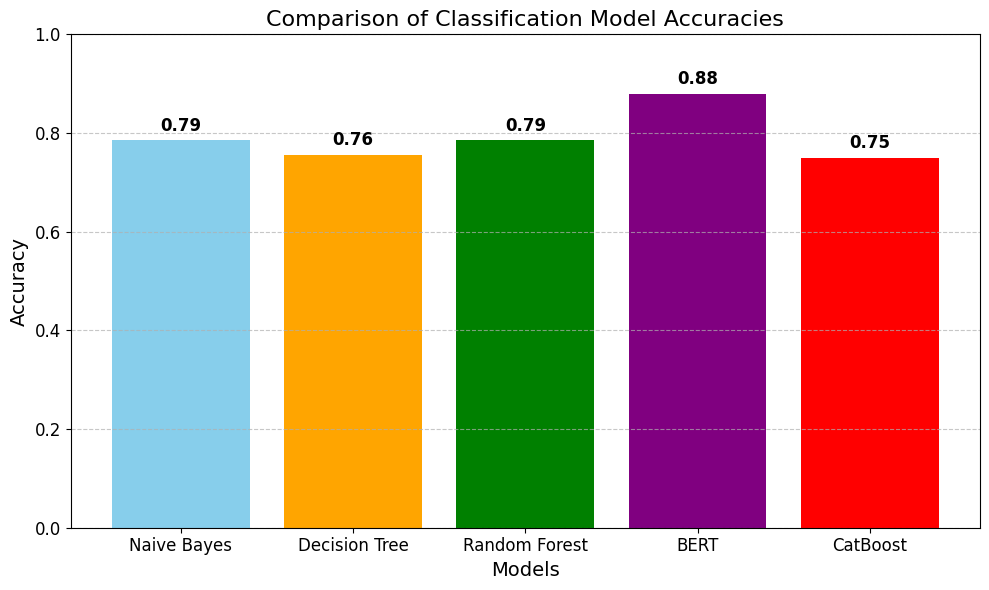

In [7]:
# Visualization that compares the classifications done
import matplotlib.pyplot as plt

model_names = [
    "Naive Bayes",
    "Decision Tree",
    "Random Forest",
    "BERT",
    "CatBoost"
]
accuracies = [
    accuracy_score(y_test, classifiers['Naive Bayes'].predict(X_test)),
    accuracy_score(y_test, classifiers['Decision Tree'].predict(X_test)),
    accuracy_score(y_test, classifiers['Random Forest'].predict(X_test)),
    bert_accuracy,
    catboost_accuracy
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'purple', 'red'])
plt.ylim(0, 1)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Comparison of Classification Model Accuracies", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()